In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge

from datasets import *
from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
valid = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v23v.csv')
public748 = pd.read_csv('input/public748.csv')
iafoss_v5160 = {
    'oof': pd.read_csv('input/predictions/0.758_v5_1_6_0_val.csv'),
    'pred': pd.read_csv('input/predictions/0.758_v5_1_6_0_submission.csv')}
# iafoss_v5210 = {
#     'oof': pd.read_csv('input/predictions/val_model_v5_2_1_0.csv'),
#     'pred': pd.read_csv('input/predictions/submission_model_v5_2_1_0.csv')}
# iafoss_v7000 = {
#     'oof': pd.read_csv('input/predictions/0.756_v7_0_0_0_val.csv'),
#     'pred': pd.read_csv('input/predictions/0.756_v7_0_0_0_submission.csv')}
iafoss_v8000 = {
    'oof': pd.read_csv('input/predictions/0.758_v8_0_0_0c_val.csv'),
    'pred': pd.read_csv('input/predictions/0.758_v8_0_0_0c_submission.csv')}
# chris_v16 = {
#     'oof': pd.read_csv('input/predictions/valset_16_0.7036.csv'),
#     'pred': pd.read_csv('input/predictions/sub_16_bce_mse.csv')}
# chris_v18 = {
#     'oof': pd.read_csv('input/predictions/valset_18_0.6997.csv'),
#     'pred': pd.read_csv('input/predictions/sub_18_double_model.csv')}
drhb_exp200 = {
    'oof': pd.read_csv('input/predictions/old/EXP_200_BASELINE_CASHE_V4_EVAL_V23_CORRECT.csv', usecols=['id', 'pred']),
    'pred': pd.read_csv('input/predictions/old/EXP_200_BASELINE_CASHE_V4.csv')}
drhb_tsv1 = {
    'oof': pd.read_csv('input/predictions/TIME_SYNC_V1_CONVNEXT_144_OOF.csv'),
    'pred': pd.read_csv('input/predictions/TIME_SYNC_V1_CONVNEXT_144.csv')}

In [15]:
valid['is_generated_noise'] = 1 - valid[['nonstationary_H1', 'nonstationary_L1']].max(1)

In [16]:
model_paths = [
    # Path('results/ds_09_val0'),
    # Path('results/ds_09_val1'),
    # Path('results/aug_04'),
    # # Path('results/ds_14'),
    # # Path('results/ds_15'),
    # # Path('results/ds_16'),
    # # Path('results/model_02'),
    # Path('results/ds_14_prep2'),
    # Path('results/ds_17_prep2'),
    # Path('results/ds_18_prep3'),
    # Path('results/ds_18_prep7'),
    # Path('results/ds_18_lf0'),
    Path('results/ds_19_aug0'),
    # Path('results/ds_19_prep0'),
    # Path('results/ds_19_res0'),
    Path('results/ds_19_prep0_l'),
    # Path('results/ds_18_res1'),
    # Path('results/ds_18_res2'),
    Path('results/model_03'),
    Path('results/model_04'),
    Path('results/model_04_prep0'),
    Path('results/ds_20_l'),
    Path('results/ds_21'),
    Path('results/ds_20_res0'),
    Path('results/ds_21_aug1'),
    Path('results/model_05_v3'),
    Path('results/model_05_v4'),
    Path('results/model_05_v5'),
    Path('results/model_07'),
    Path('results/ds_20_mod0'),
    Path('results/ds_20_mod1'),
    Path('results/ds_20_mod2'),
]


In [17]:
prediction_df = {}
oof_df = {}
for p in model_paths:
    pred = sigmoid(np.load(p/'predictions_tta.npy'))
    oof = sigmoid(np.load(p/'outoffolds_tta.npy'))
    prediction_df[p.stem] = pred.reshape(-1)
    oof_df[p.stem] = oof.reshape(-1)
    pd.DataFrame({'id': valid['id'], 'target': oof.reshape(-1)}).to_csv(f'input/predictions/kuma/{p.stem}_oof_v23.csv', index=False)
    pd.DataFrame({'id': test['id'], 'target': pred.reshape(-1)}).to_csv(f'input/predictions/kuma/{p.stem}_prediction.csv', index=False)


prediction_df = pd.DataFrame(prediction_df)
prediction_df['id'] = test['id']
# prediction_df['iafoss_v5160'] = iafoss_v5160['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v5210'] = iafoss_v5210['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v7000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
prediction_df['drhb_exp200'] = drhb_exp200['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v16'] = chris_v16['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v18'] = chris_v18['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v7000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
prediction_df['iafoss_v8000'] = iafoss_v8000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['drhb_tsv1'] = drhb_tsv1['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
oof_df = pd.DataFrame(oof_df)
oof_df['id'] = valid['id']
# oof_df['iafoss_v5160'] = iafoss_v5160['oof']['target']
# oof_df['iafoss_v5210'] = iafoss_v5210['oof']['target']
# oof_df['iafoss_v7000'] = iafoss_v7000['oof']['target']
oof_df['drhb_exp200'] = drhb_exp200['oof']['pred']
# oof_df['chris_v16'] = chris_v16['oof']['target']
# oof_df['chris_v18'] = chris_v18['oof']['target']
# oof_df['iafoss_v7000'] = iafoss_v7000['oof']['target']
oof_df['iafoss_v8000'] = iafoss_v8000['oof'].merge(oof_df[['id']], on='id', how='right')['target']
# oof_df['drhb_tsv1'] = drhb_tsv1['oof'].merge(oof_df[['id']], on='id', how='right')['target']

In [18]:
oof_df['target'] = valid['target']
oof_df.dropna(inplace=True)
oof_df = oof_df.merge(valid[['id', 'is_generated_noise']], on='id', how='left')

In [14]:
valid['id'] = valid['id'].str[:-4]
prediction_df = prediction_df.merge(valid[['id', 'is_generated_noise']], on='id', how='left')

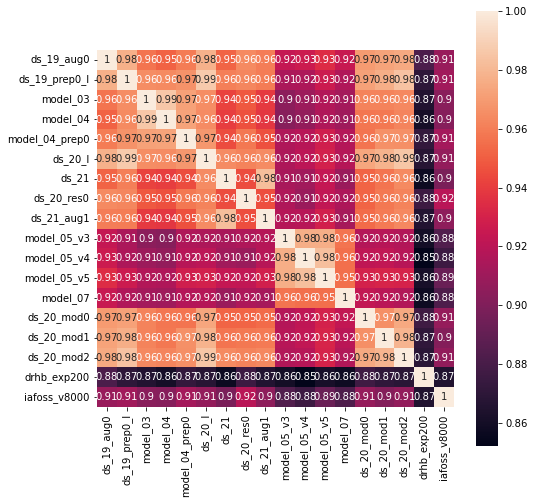

In [15]:
plt.figure(figsize=(8, 8))
sns.heatmap(prediction_df.drop('is_generated_noise', axis=1).corr(), square=True, annot=True)
plt.show()

In [16]:
model = Ridge(positive=True)
X = oof_df.drop(['target', 'id', 'is_generated_noise'], axis=1)
y = oof_df['target']
X_test = prediction_df.drop(['id', 'is_generated_noise'], axis=1)
model.fit(X, y)
y_pred = model.predict(X)
y_stack = model.predict(X_test)
print('stacking cv', roc_auc_score(y, y_pred))
print('weight', model.coef_)

stacking cv 0.7917430757701158
weight [0.         0.06943467 0.07605023 0.1918174  0.12854851 0.1006507
 0.02860312 0.09804024 0.         0.         0.06766465 0.07019609
 0.05681367 0.03907804 0.00945746 0.08796033 0.         0.0247695 ]


In [17]:
y_stack

array([0.47021838, 1.0163147 , 0.42128259, ..., 0.4519409 , 0.45545797,
       0.44670635])

In [18]:
# test['target'] = prediction_df['model_03']
test['target'] = y_stack

In [19]:
test

,id,target
0,00054c878,0.470218
1,0007285a3,1.016315
2,00076c5a6,0.421283
3,001349290,0.933008
4,001a52e92,0.955432
...,...,...
7970,ffbce04ef,1.016902
7971,ffc2d976b,0.514880
7972,ffc905909,0.451941
7973,ffe276f3e,0.455458


In [14]:
X.columns

Index(['ds_19', 'ds_19_prep0_l', 'model_03', 'drhb_exp200', 'iafoss_v8000'], dtype='object')

In [15]:
name = '_'.join(X.columns)

In [16]:
test.to_csv(f'results/stacking_{name}.csv', index=False)
# test.to_csv(Path('results/model_03')/'submission.csv', index=False)

# Separate

In [17]:
gleb_oof = pd.read_csv('input/predictions/CV23_gleb_7801_STAT_2x2tta_e073_t150_cmax_0.7686.csv')
gleb_pred = pd.read_csv('input/predictions/gleb_e073_t150_cmax_0.7686_2d2vTTA_STAT_ONLY.csv')
gleb_oof.columns = ['id', 'gleb']
gleb_pred.columns = ['id', 'gleb']
oof_df = oof_df.merge(gleb_oof, on='id', how='right')
oof_df

,ds_19,ds_19_prep0_l,model_03,id,drhb_exp200,iafoss_v8000,target,is_generated_noise,gleb
0,0.437987,0.425105,0.469050,00054c878_gen,0.265349,0.484375,0,1,0.631977
1,0.481549,0.480884,0.518737,0007285a3_gen,0.297389,0.525391,1,1,0.672596
2,0.537548,0.546803,0.531273,00076c5a6_gen,0.421611,0.560059,0,1,0.635064
3,1.000000,0.999998,0.999999,001349290_gen,0.999995,0.987793,1,1,0.947235
4,0.452154,0.438807,0.430400,001a52e92_gen,0.244278,0.454834,0,1,0.659271
...,...,...,...,...,...,...,...,...,...
6473,0.470455,0.452594,0.599857,ffb5b60b1_gen,0.281093,0.455322,0,1,0.639642
6474,0.999998,0.999993,1.000000,ffbce04ef_gen,0.999996,0.980957,1,1,0.946597
6475,0.479864,0.468823,0.534222,ffc2d976b_gen,0.300561,0.491455,0,1,0.667904
6476,0.402699,0.398299,0.419820,ffc905909_gen,0.246879,0.454346,1,1,0.676838


In [18]:
prediction_df = prediction_df.merge(gleb_pred, on='id', how='left')
prediction_df

,ds_19,ds_19_prep0_l,model_03,id,drhb_exp200,iafoss_v8000,is_generated_noise,gleb
0,0.421400,0.434326,0.455823,00054c878,0.356428,0.499268,1,0.655170
1,0.999384,0.999847,0.959431,0007285a3,0.999973,0.982422,1,0.946745
2,0.402242,0.397333,0.428347,00076c5a6,0.268465,0.435303,1,0.620628
3,0.777102,0.817488,0.967586,001349290,0.779437,0.621582,1,0.940022
4,0.830524,0.975088,0.989925,001a52e92,0.997136,0.876465,1,0.771283
...,...,...,...,...,...,...,...,...
7970,0.999999,1.000000,0.999858,ffbce04ef,0.999996,0.990234,1,0.945339
7971,0.528727,0.518646,0.559962,ffc2d976b,0.420342,0.635742,1,0.652915
7972,0.436106,0.446654,0.449506,ffc905909,0.213687,0.487061,1,0.630594
7973,0.415357,0.428251,0.473539,ffe276f3e,0.271413,0.577637,1,0.677258


In [19]:
oof_df2 = oof_df.dropna()

In [20]:
prediction_df

,ds_19,ds_19_prep0_l,model_03,id,drhb_exp200,iafoss_v8000,is_generated_noise,gleb
0,0.421400,0.434326,0.455823,00054c878,0.356428,0.499268,1,0.655170
1,0.999384,0.999847,0.959431,0007285a3,0.999973,0.982422,1,0.946745
2,0.402242,0.397333,0.428347,00076c5a6,0.268465,0.435303,1,0.620628
3,0.777102,0.817488,0.967586,001349290,0.779437,0.621582,1,0.940022
4,0.830524,0.975088,0.989925,001a52e92,0.997136,0.876465,1,0.771283
...,...,...,...,...,...,...,...,...
7970,0.999999,1.000000,0.999858,ffbce04ef,0.999996,0.990234,1,0.945339
7971,0.528727,0.518646,0.559962,ffc2d976b,0.420342,0.635742,1,0.652915
7972,0.436106,0.446654,0.449506,ffc905909,0.213687,0.487061,1,0.630594
7973,0.415357,0.428251,0.473539,ffe276f3e,0.271413,0.577637,1,0.677258


In [21]:
model = Ridge(positive=True)
X = oof_df2.drop(['target', 'id', 'is_generated_noise'], axis=1)
y = oof_df2['target']
X_test = prediction_df.query('is_generated_noise == 1').drop(['id', 'is_generated_noise'], axis=1)
model.fit(X, y)
y_pred = model.predict(X)
y_test2 = model.predict(X_test)
print('stacking cv', roc_auc_score(y, y_pred))
print('weight', model.coef_)

stacking cv 0.7919906971372083
weight [0.23098035 0.28592585 0.26526427 0.         0.09064267 0.31475226]


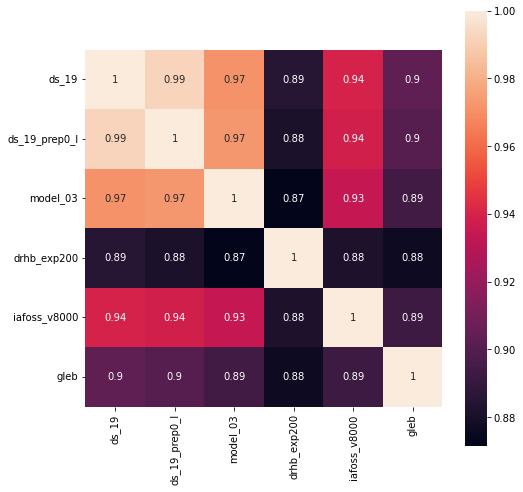

In [22]:
plt.figure(figsize=(8, 8))
sns.heatmap(X.corr(), square=True, annot=True)
plt.show()

In [23]:
for col in X.columns:
    print(col, roc_auc_score(y, X[col]))

ds_19 0.7829830074557087
ds_19_prep0_l 0.7843279798418157
model_03 0.7778128336024093
drhb_exp200 0.7554103038929517
iafoss_v8000 0.7681004652280661
gleb 0.780130640508133


In [24]:
test.loc[prediction_df['is_generated_noise'] == 1, 'target'] = y_test2

In [25]:
test.to_csv(f'results/stacking_{name}_gleb7801.csv', index=False)

# Trad blending

In [38]:
blend_df = dict(
    # COMB7=pd.read_csv('input/predictions/COMB_7.csv')['target'], # LB 0.771
    # stacking_res=y_stack, # stack with only my model cv 0.739
    # drhb_exp200=prediction_df['drhb_exp200'], # LB 0.754 (add because it has no CV/LB corr)
    # iafoss_5160=prediction_df['iafoss_v5160'], # LB 0.758
    # iafoss_5210=prediction_df['iafoss_v5210'], # LB 0.757
    # public761=pd.read_csv('input/public761.csv')['target']
    # COMB13_RB=pd.read_csv('input/predictions/COMB_13_REAL_BLENDING_0.4_0.6.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_17_prep2=pd.read_csv('results/ds_17_prep2/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_17_prep1=pd.read_csv('results/ds_17_prep1_beforefix/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_18_prep3=pd.read_csv('results/ds_18_prep3/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_18_prep7=pd.read_csv('results/ds_18_prep7/submission.csv').merge(test['id'], on='id', how='right')['target'],
    blend_comb13rb_ds17prep2=pd.read_csv('results/blend_comb13rb_ds17prep2.csv')['target'],
    # stacking_776=pd.read_csv('results/stacking_ds_19_ds_19_prep0_ds_18_res1_model_03_model_04_model_04_prep0_iafoss_v8000_drhb_tsv1.csv')['target'],
    stacking_777=pd.read_csv('results/stacking_ds_19_ds_19_prep0_model_03_drhb_exp200_iafoss_v8000.csv')['target'],
    drhb_tsv1=pd.read_csv('input/predictions/TIME_SYNC_V1_CONVNEXT_144.csv')['target']
)
blend_df = pd.DataFrame(blend_df)
blend_df = blend_df.rank(axis=0)
blend_df = blend_df / blend_df.max(axis=0).values[None, :]

In [39]:
blend_df.corr()

,blend_comb13rb_ds17prep2,stacking_777,drhb_tsv1
blend_comb13rb_ds17prep2,1.000000,0.877236,0.841898
stacking_777,0.877236,1.000000,0.906092
drhb_tsv1,0.841898,0.906092,1.000000


In [40]:
blend_df['target'] = \
    blend_df['blend_comb13rb_ds17prep2'] * 0.7 + blend_df['stacking_777'] * 0.2 + blend_df['drhb_tsv1'] * 0.1

In [24]:
test['target'] = blend_df['target']
test.to_csv(Path('results/blend_(blend_comb13rb_ds17prep2)_(stacking_777)_(drhb_tsv1).csv'), index=False)

# Leak

In [63]:
leak_target = pd.read_csv('input/denoised_target_negative.csv')
origin_sub = pd.read_csv('input/predictions/ds_20_l_prediction.csv')
best_sub = pd.read_csv('input/predictions/submission785.csv')
with open('input/g2net-detecting-continuous-gravitational-waves/leak_1.pickle', 'rb') as handle:
    clean_data = pickle.load(handle)

In [64]:
leak_target['coverage'] = leak_target['id'].apply(lambda x: 0.5*(clean_data[x]['coverage_H1']+clean_data[x]['coverage_L1']).item())

In [65]:
leak_target.loc[leak_target['coverage'] > 0.95, 'target'] = 0

In [66]:
leak_target

,id,target,coverage
0,8603bf1e2,0.000000,1.000000
1,0177a2d23,0.763201,0.236111
2,a1722b207,0.491382,0.472222
3,03ac90f05,0.552630,0.472222
4,05fa8cd9d,0.534778,0.213889
...,...,...,...
202,d6828b59a,0.535158,0.152778
203,f6ccedec7,0.557439,0.541667
204,e2b2204dd,0.535016,0.541667
205,f1685778b,0.552491,0.650000


In [67]:
origin_sub.merge(leak_target, on='id', how='inner').head(50)

,id,target_x,target_y,coverage
0,0177a2d23,0.734442,0.763201,0.236111
1,03ac90f05,0.528636,0.552630,0.472222
2,0559d7491,0.490796,0.543049,0.213889
3,05fa8cd9d,0.455408,0.534778,0.213889
4,07f958d83,0.999939,0.000000,1.000000
5,096b8094b,0.538486,0.573452,0.522222
6,0ab0bb87c,0.419513,1.000000,0.930556
7,0bf7da48d,0.572962,0.569935,0.613889
8,0d6164664,0.539728,0.552249,0.297222
9,0de7c7655,0.457473,0.454464,0.152778


In [68]:
replace_dict = leak_target.set_index('id').to_dict()['target']
origin_sub['target'] = origin_sub[['id', 'target']].apply(
    lambda x: replace_dict[x['id']] if x['id'] in replace_dict.keys() and replace_dict[x['id']] <= x['target'] else x['target'], axis=1)

In [69]:
origin_sub['target'] = origin_sub['target'].rank(0)
origin_sub['target'] /= origin_sub['target'].max()

In [70]:
replace_dict2 = origin_sub.loc[origin_sub['id'].isin(leak_target['id'])].set_index('id').to_dict()['target']

In [71]:
best_sub['target'] = best_sub[['id', 'target']].apply(
    lambda x: replace_dict2[x['id']] if x['id'] in replace_dict2.keys() else x['target'], axis=1)

In [72]:
pd.DataFrame(best_sub['target'] - pd.read_csv('input/predictions/submission785.csv')['target']).query('target != 0')

,target
56,0.031837
128,-0.038069
176,0.046320
199,0.016251
250,-0.825129
...,...
7814,0.006270
7873,0.057329
7913,-0.058784
7962,-0.097906


In [100]:
best_sub.to_csv('results/blend_v2_leak_2.csv', index=False)